In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
!pip install squarify
import squarify

In [2]:
import sqlite3

#Preparation and Download of database

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ABC_2b_jan23.xlsx', sheet_name='Лист1')

In [4]:
df.head()

,сц2,сц,Бренд,ТипЗаказа,Регион,ВидАналитики,Артикул,Номенклатура,Ед ном,Источник,Выручка,Кол-во товаров,Цена,Группа,С/с
0,2berega4251,ВЕЛИКИЙ НОВГОРОД4251,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,4251,Блины с ветчиной и сыром,Блинчики с ветчиной и сыром,web,249,1.0,269.0,блины,72.29
1,2berega17665,ВЕЛИКИЙ НОВГОРОД17665,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17665,Блины с грибным жульеном,Блинчики с грибным жюльеном,web,230,1.0,249.0,блины,62.92
2,2berega17790,ВЕЛИКИЙ НОВГОРОД17790,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17790,Блины со сгущенкой 2 шт рег,Блины со сгущенкой,partner,209,1.0,209.0,блины,34.32
3,2berega17790,ВЕЛИКИЙ НОВГОРОД17790,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17790,Блины со сгущенкой 2 шт рег,Блины со сгущенкой,web,196,1.0,209.0,блины,34.32
4,2berega17791,ВЕЛИКИЙ НОВГОРОД17791,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17791,Блины с лососем и творожным сыром 2 шт рег,Блины с лососем и творожным сыром,web,698,2.0,379.0,блины,80.58


In [5]:
df = df.drop(['сц2','сц','Номенклатура','Группа'], axis=1)

In [6]:
df.columns=['brand','order_type','region', 'category', 'product_id', 'name', 'source', 'revenue', 'amount', 'price', 'cost']

In [7]:
df.head()

,brand,order_type,region,category,product_id,name,source,revenue,amount,price,cost
0,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,4251,Блинчики с ветчиной и сыром,web,249,1.0,269.0,72.29
1,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17665,Блинчики с грибным жюльеном,web,230,1.0,249.0,62.92
2,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17790,Блины со сгущенкой,partner,209,1.0,209.0,34.32
3,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17790,Блины со сгущенкой,web,196,1.0,209.0,34.32
4,2berega,delivery,ВЕЛИКИЙ НОВГОРОД,блины,17791,Блины с лососем и творожным сыром,web,698,2.0,379.0,80.58


##Let's choose for analysis only one brand and city with the biggest revenue.

In [8]:
df.groupby('brand')['revenue'].sum().sort_values(ascending=False)

,revenue
brand,
2berega,116103411
FoodTaxi,112470647
Olli,78839284
Empire,34741169
Rumya,18856411
CityP,14726188
WasBi,10328832
GotKit,7227059
MR,5024450


In [9]:
df.groupby('region')['revenue'].sum().sort_values(ascending=False)

,revenue
region,
САНКТ-ПЕТЕРБУРГ,285037441
МОСКВА,54788440
РОСТОВ-НА-ДОНУ,21632929
КАЗАНЬ,11654517
КАЛИНИНГРАД,11067861
САМАРА,7814229
УФА,4539604
ЧЕЛЯБИНСК,4451567
ЕКАТЕРИНБУРГ,3689646


In [10]:
twob = df[(df['brand']=='2berega') & (df['region']=='САНКТ-ПЕТЕРБУРГ')].drop(['brand','region'],axis=1)

##Check and correct data type.

In [11]:
twob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1605 entries, 5078 to 8551
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_type  1605 non-null   object 
 1   category    1605 non-null   object 
 2   product_id  1605 non-null   int64  
 3   name        1605 non-null   object 
 4   source      1605 non-null   object 
 5   revenue     1605 non-null   int64  
 6   amount      1605 non-null   float64
 7   price       1569 non-null   float64
 8   cost        1526 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 125.4+ KB


In [12]:
twob['revenue'] = twob['revenue'].astype('float')

In [13]:
con = sqlite3.connect('db')

In [14]:
twob.to_sql('twob', con, index=False, if_exists='replace')

1605

In [15]:
def select(sql):
  return pd.read_sql(sql, con)

#Write a ABC query

In [16]:
sql='''
with grouped as (select t.name,
t.category,
sum(t.amount) as amount,
sum(t.revenue) as revenue,
sum(t.revenue) - sum(t.amount) * max(t.cost) as gross_profit
from twob t
group by t.name, t.category
order by 3 desc), ---aggregate data based on item and category

share as (select *,
g.amount / sum(g.amount) over() as amount_share,
g.revenue*1.0 / sum(g.revenue) over() as rev_share,
g.gross_profit / sum(g.gross_profit) over() as gr_profit_share
from grouped g), ---observe share of each indicator

cumsum_db as (select *,
sum(s.amount_share) over(order by s.amount_share desc) as amount_cumsum,
sum(s.rev_share) over(order by s.rev_share desc) as rev_cumsum,
sum(s.gr_profit_share) over(order by s.gr_profit_share desc) as gr_profit_cumsum
from share s), ---calculate cumulative amounts

abc_full as (select c.name,
c.amount,
c.amount_share,
CASE
    WHEN c.amount_cumsum < 0.8 THEN 'A'
    WHEN c.amount_cumsum < 0.95 THEN 'B'
    ELSE 'C'
END AS amount_abc,
c.revenue, c.rev_share,
CASE
    WHEN c.rev_cumsum < 0.8 THEN 'A'
    WHEN c.rev_cumsum < 0.95 THEN 'B'
    ELSE 'C'
END AS rev_abc,
c.gross_profit, c.gr_profit_share,
CASE
    WHEN gr_profit_cumsum < 0.8 THEN 'A'
    WHEN gr_profit_cumsum < 0.95 THEN 'B'
    ELSE 'C'
END AS gr_profit_abc
from cumsum_db c) ---assign A,B or C value based on digit in cumsum colums

select a.name,c.category,a.amount,round(c.amount_cumsum *100,2)as cum_amount, a.amount_abc,
a.revenue,round(c.rev_cumsum *100,2) as cum_revenue,a.rev_abc,
a.gross_profit,round(c.gr_profit_cumsum *100,2) as cum_profit,a.gr_profit_abc,
(a.amount_abc||a.rev_abc||a.gr_profit_abc) as ABC_arp ---make complex ABC segment
from abc_full a
join cumsum_db c on a.name=c.name'''

In [17]:
select(sql)

,name,category,amount,cum_amount,amount_abc,revenue,cum_revenue,rev_abc,gross_profit,cum_profit,gr_profit_abc,ABC_arp
0,ЛОСОСЬ СТАНДАРТ Филадельфия,классические роллы,8289.0,4.56,A,3001173.0,3.20,A,1701623.58,2.58,A,AAA
1,Дополнительный набор,сопутствующие товары,4934.0,7.28,A,233365.0,77.52,A,161575.30,78.40,A,AAA
2,Четыре сыра Пицца тонк. тесто,на тонком тесте,3861.0,9.41,A,2044572.0,13.27,A,1558742.37,7.39,A,AAA
3,Пепперони Пицца тонк. тесто,на тонком тесте,3334.0,11.24,A,1587567.0,16.94,A,1235963.36,15.54,A,AAA
4,Сет Фейрверк,промо наборы,3012.0,12.90,A,2781985.0,6.16,A,1610949.52,5.03,A,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...
375,Набор Вечер для двоих,промо наборы,1.0,100.00,C,1250.0,100.00,C,NaN,100.00,C,CCC
376,Набор Пати стартер,промо наборы,1.0,100.00,C,1170.0,100.00,C,718.46,100.00,C,CCC
377,Филадельфия с угрём люкс,классические роллы,1.0,100.00,C,432.0,100.00,C,NaN,100.00,C,CCC
378,Ролл тунец темпура,классические роллы,1.0,100.00,C,305.0,100.00,C,NaN,100.00,C,CCC


In [18]:
abc = select(sql)

#Distribution of assortment by ABC categories

In [19]:
revenue_abc = abc.pivot_table(index='rev_abc', values=['revenue','name'],aggfunc={'name':"count",'revenue':"sum"}).reset_index()
revenue_abc['items_share'] = (revenue_abc['name'] / revenue_abc['name'].sum() * 100).round(2)

In [20]:
revenue_abc

,rev_abc,name,revenue,items_share
0,A,125,74980023.0,32.89
1,B,108,14178362.0,28.42
2,C,147,4734430.0,38.68


In [21]:
amount_abc = abc.pivot_table(index='amount_abc', values=['amount','name'],aggfunc={'name':"count",'amount':"sum"}).reset_index()
amount_abc['items_share'] = (amount_abc['name'] / amount_abc['name'].sum() * 100).round(2)

In [22]:
amount_abc

,amount_abc,amount,name,items_share
0,A,145161.0,149,39.21
1,B,27238.0,107,28.16
2,C,9223.0,124,32.63


In [23]:
profit_abc = abc.pivot_table(index='gr_profit_abc', values=['gross_profit','name'],aggfunc={'name':"count",'gross_profit':"sum"}).reset_index()
profit_abc['items_share'] = (profit_abc['name'] / profit_abc['name'].sum() * 100).round(2)

In [24]:
profit_abc

,gr_profit_abc,gross_profit,name,items_share
0,A,52587908.80,121,31.84
1,B,9968358.01,103,27.11
2,C,3317338.36,156,41.05


In [25]:
ttl_abc = abc.pivot_table(index='ABC_arp', values='name',aggfunc="count").reset_index().sort_values(by='name', ascending=False)
ttl_abc['items_share'] = (ttl_abc['name'] / ttl_abc['name'].sum() * 100).round(1)
ttl_abc

,ABC_arp,name,items_share
14,CCC,101,26.6
0,AAA,98,25.8
7,BBB,47,12.4
9,BCC,38,10.0
3,ABB,33,8.7
6,BAA,17,4.5
11,CBB,16,4.2
5,ACC,7,1.8
1,AAB,6,1.6
8,BBC,5,1.3


In [26]:
abc_agg = revenue_abc[['rev_abc',	'name',	'revenue','items_share']]\
.merge(amount_abc[['amount_abc',	'amount',	'name',	'items_share']], how='left'\
       , left_on='rev_abc', right_on='amount_abc', suffixes=('_rev','_amount'))\
       .merge(profit_abc[['gr_profit_abc',	'gross_profit',	'name',	'items_share']], how='left'\
       , left_on='rev_abc', right_on='gr_profit_abc', suffixes=('_rev','_gr_prof'))

In [27]:
abc_agg = abc_agg.drop(['amount_abc','gr_profit_abc'],axis=1).rename(columns={'name_rev':'items_rev',
                                                                    'name_amount':'items_amount',
                                                                    'name':'items_gross_prof',
                                                                    'items_share':'items_share_gross_prof'})
abc_agg

,rev_abc,items_rev,revenue,items_share_rev,amount,items_amount,items_share_amount,gross_profit,items_gross_prof,items_share_gross_prof
0,A,125,74980023.0,32.89,145161.0,149,39.21,52587908.80,121,31.84
1,B,108,14178362.0,28.42,27238.0,107,28.16,9968358.01,103,27.11
2,C,147,4734430.0,38.68,9223.0,124,32.63,3317338.36,156,41.05


#Visualisation and Results

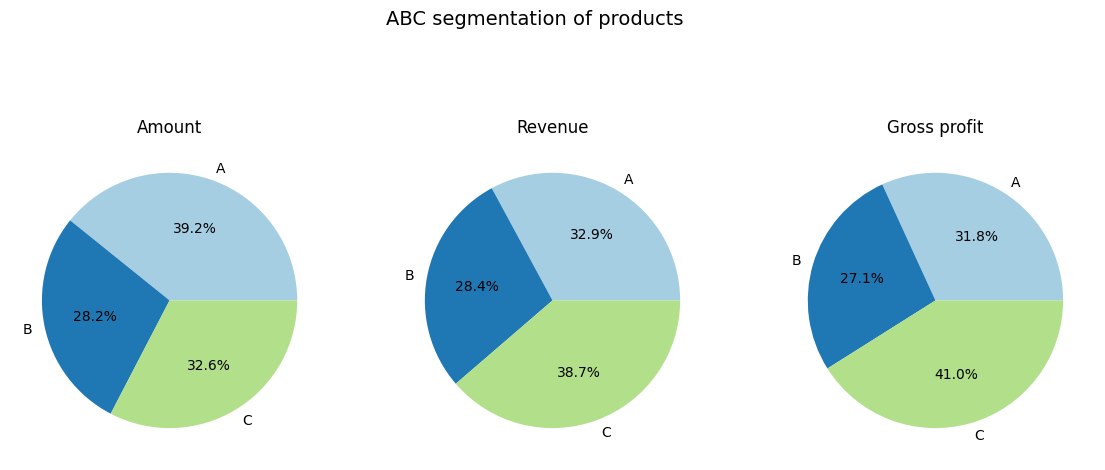

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('ABC segmentation of products', fontsize=14)

#amount
revenue = abc_agg['items_share_amount']
ax2 = axes[0].pie(revenue, labels=abc_agg['rev_abc'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set(title="Amount")

#revenue
revenue = abc_agg['items_share_rev']
ax1 = axes[1].pie(revenue, labels=abc_agg['rev_abc'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set(title="Revenue")

#gross profit
revenue = abc_agg['items_share_gross_prof']
ax3 = axes[2].pie(revenue, labels=abc_agg['rev_abc'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[2].set(title="Gross profit")

plt.show()

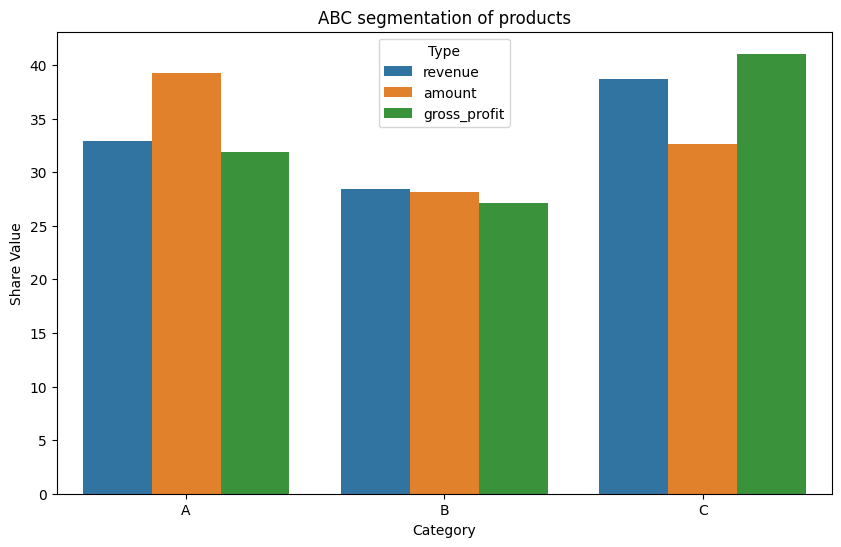

In [29]:
abc_melted = abc_agg.melt(id_vars=['rev_abc'],
                          value_vars=['items_share_rev', 'items_share_amount', 'items_share_gross_prof'],
                          var_name='Type', value_name='Value')\
                          .replace({'items_share_rev':'revenue',
                                    'items_share_amount':'amount',
                                    'items_share_gross_prof':'gross_profit'})


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='rev_abc', y='Value', hue='Type', data=abc_melted)
plt.xlabel('Category')
plt.ylabel('Share Value')
plt.title('ABC segmentation of products')
plt.legend(title='Type')
plt.show()

We observe that more then 30% of items generate about 80% of revenue, sold amount and gross profit.  
Category B is nearly the same for all used indicators and it ia about 27-28% of all items.  
Category C makes up the majority of positions of revenue (38.7%) and gross profit (41%), which requires additional attention.

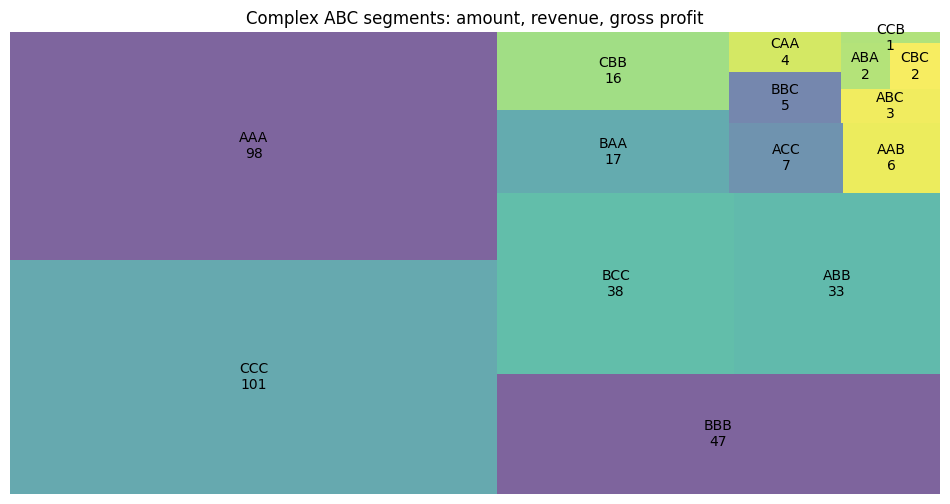

In [30]:
plt.figure(figsize=(12, 6))
labels = [f"{label}\n{value}" for label, value in zip(ttl_abc['ABC_arp'], ttl_abc['name'])]
squarify.plot(sizes=ttl_abc['name'], label=labels, alpha=0.7)
plt.title("Complex ABC segments: amount, revenue, gross profit")
plt.axis('off')
plt.show()

In [31]:
fig = px.treemap(ttl_abc,path=['ABC_arp'], values='items_share', title="Complex ABC segments: amount, revenue, gross profit")
fig.update_traces(textinfo="label+value")
fig.show()

Most products are categorized into distinct segments such as AAA or BBB.

Categories ABB and BCC consist of items that, while well-sold, do not significantly contribute to profitability. To enhance margins, we should focus on optimizing their pricing and cost structures. Currently, ABB and BCC account for 8.7% and 10% of our inventory, respectively.

On the other hand, categories BAA (4.5%) and CBB (4.2%) comprise items with lower sales volumes but higher profitability. This could be due to their pricing or unique features. To leverage these products further, we should consider implementing promotional programs to boost sales.



#Top5 products in each category

Here we can see Top5 products in each complex ABC segment, to know, wich items we should work at first.

In [32]:
meow = abc['ABC_arp'].unique()
for category in meow:
    category_top5 = abc[['name','category','amount','revenue','gross_profit']][abc['ABC_arp'] == category].sort_values(by='revenue', ascending=False).head(5)
    print(f"\033[1mTop 5 items for category {category}:\033[0m")
    print(category_top5)
    print()


Top 5 items for category AAA:
                             name            category  amount    revenue  \
0     ЛОСОСЬ СТАНДАРТ Филадельфия  классические роллы  8289.0  3001173.0   
4                    Сет Фейрверк        промо наборы  3012.0  2781985.0   
9             Набор Много половин        промо наборы  2120.0  2338625.0   
17                   Набор Профит        промо наборы  1618.0  2293521.0   
2   Четыре сыра Пицца тонк. тесто     на тонком тесте  3861.0  2044572.0   

    gross_profit  
0     1701623.58  
4     1610949.52  
9     1512927.40  
17    1350534.42  
2     1558742.37  

Top 5 items for category ACC:
                                     name                category  amount  \
74                       Пирожок с вишней                 десерты   734.0   
124  Эвервесс «Искрящийся Лимон-Лайм» 1 л  напитки безалкогольные   428.0   
24                            Сырный соус            топпинг соус  1457.0   
100                  Пирожок Лесные ягоды                 де